Purpose: To choose optimal model specifics for GARCH

Libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from hmmlearn import hmm

In [78]:
from alpha_vantage.timeseries import TimeSeries
api_key = "FDBZFAVWCZC4S841"

ts = TimeSeries(key=api_key, output_format="pandas")


df, meta_data = ts.get_daily(symbol="MSFT", outputsize="full")

df.columns = ["Open", "High", "Low", "Close", "Volume"]

df

,Open,High,Low,Close,Volume
date,,,,,
2025-02-19,407.88,415.490,407.6500,414.77,24114197.0
2025-02-18,408.00,410.597,406.5000,409.64,21423051.0
2025-02-14,407.79,408.910,405.8800,408.43,22758464.0
2025-02-13,407.00,411.000,406.3600,410.54,23891731.0
2025-02-12,407.21,410.750,404.3673,409.04,19121734.0
...,...,...,...,...,...
1999-11-05,91.81,92.870,90.5000,91.56,35083700.0
1999-11-04,92.31,92.750,90.3100,91.75,27119700.0
1999-11-03,92.94,93.500,91.5000,92.00,22258500.0


In [79]:
prices = df['Close'].values
log_prices = np.log(prices)
returns = np.diff(log_prices).reshape(-1, 1)

In [80]:
log_prices = np.log(prices)
returns = np.diff(log_prices).reshape(-1, 1)

In [81]:
n_states = 3  # You can adjust this number based on your hypothesis about market regimes
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
model.fit(returns)

GaussianHMM(n_components=3, n_iter=1000)

In [82]:
hidden_states = model.predict(returns)

In [83]:
data = df.iloc[1:].copy()
data['state'] = hidden_states

In [84]:
data

,Open,High,Low,Close,Volume,state
date,,,,,,
2025-02-18,408.00,410.597,406.5000,409.64,21423051.0,2
2025-02-14,407.79,408.910,405.8800,408.43,22758464.0,2
2025-02-13,407.00,411.000,406.3600,410.54,23891731.0,2
2025-02-12,407.21,410.750,404.3673,409.04,19121734.0,2
2025-02-11,409.64,412.490,409.3000,411.44,18140592.0,2
...,...,...,...,...,...,...
1999-11-05,91.81,92.870,90.5000,91.56,35083700.0,0
1999-11-04,92.31,92.750,90.3100,91.75,27119700.0,0
1999-11-03,92.94,93.500,91.5000,92.00,22258500.0,0


In [85]:
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']  # Adjust if you have more states

<Figure size 1200x600 with 0 Axes>

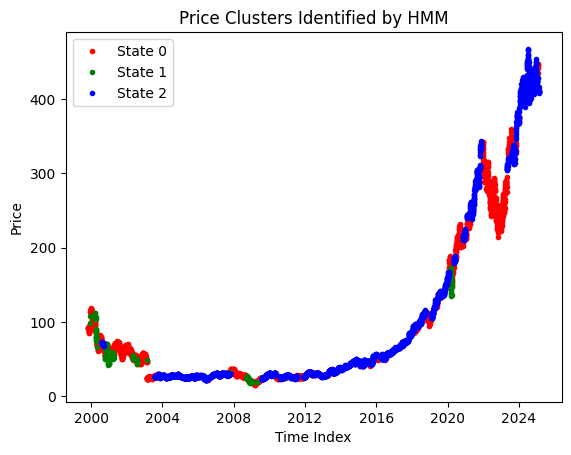

In [86]:
for state in range(n_states):
    state_data = data[data['state'] == state]
    plt.plot(state_data.index, state_data['Close'], '.', color=colors[state], label=f"State {state}")

plt.xlabel('Time Index')
plt.ylabel('Price')
plt.title('Price Clusters Identified by HMM')
plt.legend()
plt.show()

In [88]:
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

In [89]:
data['ema_bullish'] = data['EMA_50'] > data['EMA_200']

In [90]:
data['trade'] = np.where((data['ema_bullish']) & (data['state'].isin([1, 2])), 1, 0)

In [99]:
data

,Open,High,Low,Close,Volume,state,EMA_50,EMA_200,ema_bullish,trade
date,,,,,,,,,,
2025-02-18,408.00,410.597,406.5000,409.64,21423051.0,2,409.640000,409.640000,False,0
2025-02-14,407.79,408.910,405.8800,408.43,22758464.0,2,409.592549,409.627960,False,0
2025-02-13,407.00,411.000,406.3600,410.54,23891731.0,2,409.629704,409.637035,False,0
2025-02-12,407.21,410.750,404.3673,409.04,19121734.0,2,409.606578,409.631095,False,0
2025-02-11,409.64,412.490,409.3000,411.44,18140592.0,2,409.678477,409.649094,True,1
...,...,...,...,...,...,...,...,...,...,...
1999-11-05,91.81,92.870,90.5000,91.56,35083700.0,0,96.085969,88.870752,True,0
1999-11-04,92.31,92.750,90.3100,91.75,27119700.0,0,95.915931,88.899401,True,0
1999-11-03,92.94,93.500,91.5000,92.00,22258500.0,0,95.762365,88.930253,True,0


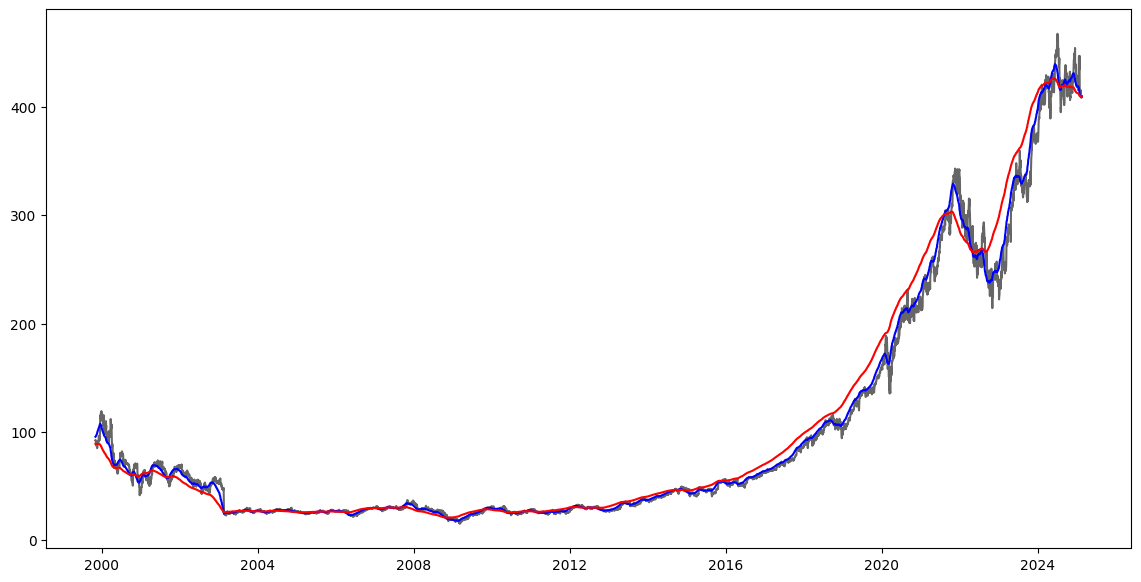

In [94]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Price', color='black', alpha=0.6)
plt.plot(data['EMA_50'], label='50 EMA', color='blue', linewidth=1.5)
plt.plot(data['EMA_200'], label='200 EMA', color='red', linewidth=1.5)


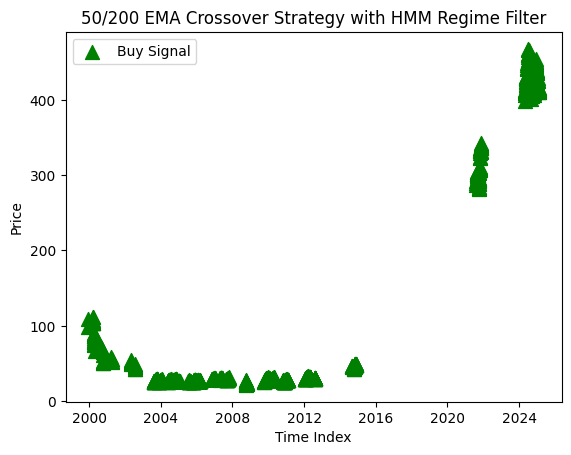

In [97]:
buy_signals = data[data['trade'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal')
plt.title('50/200 EMA Crossover Strategy with HMM Regime Filter')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [100]:
data.to_csv('trade.csv')